In [1]:
#Larq is an open-source Python library for training neural networks with extremely low-precision weights and activations,such as Binarized Neural Networks (BNNs).
pip install larq

In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import tensorflow as tf
import larq as lq
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, merge, Lambda, BatchNormalization
from keras.models import Model
from time import process_time

# Importing Data

In [3]:
dataset =pd.read_csv('./Datasets/dataset_cleaned.csv')
data = dataset.copy()
data

,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label_Num,Cat_Num,Sub_Cat_Num
0,75,1,1,982.0,1430.0,982.0,982.0,982.0,0.000000,1430.0,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,1,1,5
1,5310,1,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,1,3,3
2,141,0,3,0.0,2806.0,0.0,0.0,0.0,0.000000,1388.0,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,1,2,6
3,151,0,2,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,1,1,2
4,153,2,1,886.0,420.0,452.0,434.0,443.0,12.727922,420.0,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625410,277,1,1,18.0,18.0,18.0,18.0,18.0,0.000000,18.0,...,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,1,1,1
625411,1658,0,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,1,3,3
625412,77,1,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,1,2,6
625413,240,2,1,2776.0,1388.0,1388.0,1388.0,1388.0,0.000000,1388.0,...,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,0,0,0


# Variance method - Feature Selection

Removing features that show the same value for the majority/all of the observations (constant/quasi-constant features)

In [4]:
def constant_feature_detect(data,threshold=0.98):

   
    quasi_constant_feature = []
    for feature in data.columns:
        predominant = (data[feature].value_counts() / np.float(
                      len(data))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),' variables are found to be almost constant')    
    return quasi_constant_feature


# the original dataset has no constant variable
quasi_constant_feature = constant_feature_detect(data=data,threshold=0.9)

<ipython-input-4-312de7e45ef2>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (data[feature].value_counts() / np.float(


26  variables are found to be almost constant


In [5]:
quasi_constant_feature

['Fwd_Pkt_Len_Std',
 'Bwd_IAT_Std',
 'Fwd_PSH_Flags',
 'Bwd_PSH_Flags',
 'Fwd_URG_Flags',
 'Bwd_URG_Flags',
 'FIN_Flag_Cnt',
 'SYN_Flag_Cnt',
 'RST_Flag_Cnt',
 'PSH_Flag_Cnt',
 'URG_Flag_Cnt',
 'CWE_Flag_Count',
 'ECE_Flag_Cnt',
 'Fwd_Byts/b_Avg',
 'Fwd_Pkts/b_Avg',
 'Fwd_Blk_Rate_Avg',
 'Bwd_Byts/b_Avg',
 'Bwd_Pkts/b_Avg',
 'Bwd_Blk_Rate_Avg',
 'Init_Fwd_Win_Byts',
 'Fwd_Seg_Size_Min',
 'Active_Mean',
 'Active_Std',
 'Active_Max',
 'Active_Min',
 'Label_Num']

In [6]:
data.drop(quasi_constant_feature,axis=1,inplace=True)

In [10]:
#Divided by Label_Num
X         = dataset.iloc[:,:-3]
Y         = np.array(dataset.iloc[:,-3])
Y         = Y.reshape(len(Y),1)
#Datasette Label_Num'ın konumuna dikkat!!!

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Min-Max scaling

In [12]:
minMax= MinMaxScaler()
minMax.fit(X_train)
X_train = minMax.transform(X_train)
X_test  = minMax.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)).astype('float32') 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)).astype('float32') 

In [13]:
num_classes = 10
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

# Build Binary Neural Network(BNN)

Here we build the BinaryNet model layer by layer using the Keras Sequential API.

In [14]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv1D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(76,1)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv1D(30, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool1D(pool_size=(2), strides=(2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv1D(60, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool1D(pool_size=(2), strides=(2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv1D(120, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool1D(pool_size=(2), strides=(2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(240, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

In [15]:
lq.models.summary(model)

+sequential stats---------------------------------------------------------------------------------------+
| Layer                  Input prec.        Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                     x 1       x 1    (kB)                          |
+-------------------------------------------------------------------------------------------------------+
| quant_conv1d                     -  (-1, 74, 128)      384         0    0.05           0        28416 |
| batch_normalization              -  (-1, 74, 128)        0       256    1.00           0            0 |
| quant_conv1d_1                   1   (-1, 74, 30)    11520         0    1.41      852480            0 |
| max_pooling1d                    -   (-1, 37, 30)        0         0       0           0            0 |
| batch_normalization_1            -   (-1, 37, 30)        0        60    0.23           0            0 |
| quant_conv1d_2                   1   (-1, 37

# Model Training

In [16]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
t1_start = process_time() 
trained_model = model.fit(
    X_train, 
    Y_train,
    batch_size=256, 
    epochs=10,
    validation_data=(X_test, Y_test),
    shuffle=True
)
t1_stop = process_time()
print("time:", t1_stop-t1_start)

# Model Output

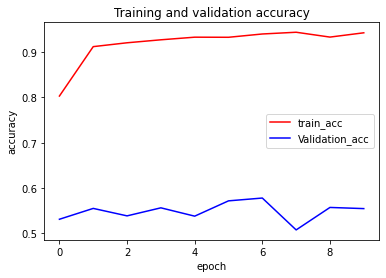

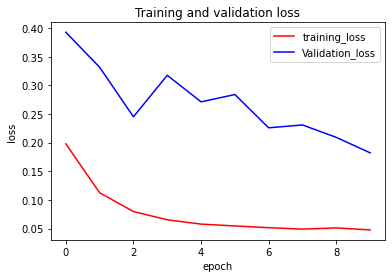

0.9435130953788757
0.5780482888221741


In [14]:
acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='train_acc')
plt.plot(epochs, val_acc, 'b', label='Validation_acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='Validation_loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')

plt.legend()
plt.show()

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

In [15]:
# confusion matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    # np.set_printoptions(precision=2)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
    
    #Roc


def plot_roc_curve(Y_test, Y_pred, nb_classes, class_index, title='Receiver operating characteristic'):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y_test[:, i], Y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(Y_test.ravel(), Y_pred.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    #plt.figure()
    lw = 2
    plt.plot(fpr[class_index], tpr[class_index], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[class_index])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


-----------------------------------------------------------------------------------------------------
Testing accuracy...
-----------------------------------------------------------------------------------------------------
0.5547725816784113
-----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.97      0.69      2365
           1       0.82      0.13      0.22      2318

    accuracy                           0.55      4683
   macro avg       0.68      0.55      0.46      4683
weighted avg       0.68      0.55      0.46      4683

-----------------------------------------------------------------------------------------------------
TP: 298 FP: 2020 TN: 2300 FN: 65
-----------------------------------------------------------------------------------------------------
Accuracy: 0.375542064180399
---------------------------------------------------------------

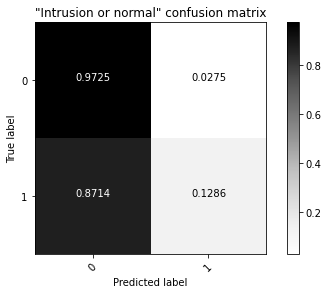

-----------------------------------------------------------------------------------------------------


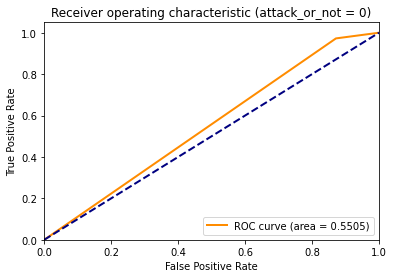

-----------------------------------------------------------------------------------------------------


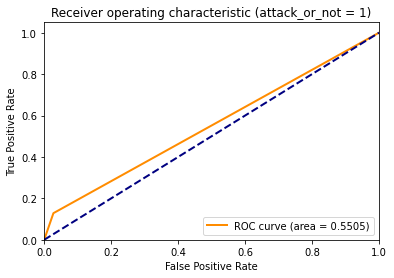

-----------------------------------------------------------------------------------------------------


In [16]:
classes = num_classes
Y_train = model.predict(X_test)
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)
print('-----------------------------------------------------------------------------------------------------')
print('Testing accuracy...')
print('-----------------------------------------------------------------------------------------------------')
score2 = accuracy_score(Y_test, np.around(Y_train))
print(score2)
print('-----------------------------------------------------------------------------------------------------')
print(classification_report(Y_test, np.around(Y_train)))
print('-----------------------------------------------------------------------------------------------------')
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    for i in range(len(y_hat)): 
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure(np.around(Y_train), Y_test)

fp_rate = FP/(TN+FP)
tn_rate = TN/(TN+FP)

accuracy = (TN+TP)/(TN+FP+TP+TN)
precision = TP/(TN+FP)
hitrate = TP/(TN+FN)

print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN)
print('-----------------------------------------------------------------------------------------------------')
print('Accuracy:', accuracy)
print('-----------------------------------------------------------------------------------------------------')
print('False Positive rate:', fp_rate, 'True Negative Rate', tn_rate)


def to_cat(y):
    y_tmp = np.ndarray(shape=(y.shape[0], 2), dtype=np.float32)
    for i in range(y.shape[0]):
        y_tmp[i, :] = np.array([1-y[i], y[i]])   # np.array([0,1]) if y[i] else np.array([1,0])
    return y_tmp


plot_confusion_matrix(Y_test, np.round(Y_train), classes=list(range(2)),
                           normalize=True,
                         title='"Intrusion or normal" confusion matrix')
print('-----------------------------------------------------------------------------------------------------')
plot_roc_curve(to_cat(Y_test), to_cat(Y_train), 2, 0, title='Receiver operating characteristic (attack_or_not = 0)')
print('-----------------------------------------------------------------------------------------------------')
plot_roc_curve(to_cat(Y_test), to_cat(Y_train), 2, 1, title='Receiver operating characteristic (attack_or_not = 1)')

print('-----------------------------------------------------------------------------------------------------')